In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# Data Prep

In [3]:
def extract_feature_columns(df):
    '''Removes all default columns (contexts as well as fields like profileid which come in every event)'''
    ndf = df.copy()
    ndf.columns = [x.split('.')[1] for x in df.columns]
    default_cols = ['appid','spaceid','sessionid','playersessionid',
                    'profileid','totalplaytime','userid','clientip','countrycode',
                    'absoluteplaytime','relativeplaytime','release','app_name','spacename',
                    'country','business_region','geo_continent','subcontinent','region',
                    'serverdate','p_dateid','createddate','environment',
                    'installmentname','issampled','offline','eventid'
                   ]
    cols = [c for c in ndf.columns if "context" not in c and c not in default_cols]
    return ndf[cols]

In [16]:
datapath = '~/edo-autoencoder/datasets'

bug_file = '{}/drone_melee_kills_1000.csv'.format(datapath)
proper_file = '{}/drone_bullet_proper_10k.csv'.format(datapath)

bug_df = pd.read_csv(bug_file)
proper_df = pd.read_csv(proper_file)

bug_df = extract_feature_columns(bug_df)
proper_df = extract_feature_columns(proper_df)

#bug_df['label'] = 1
#proper_df['label'] = 0

df = pd.concat([proper_df])

# now we are mostly done. need to identify numerical features, categorical features and remove old/useless features
bad_cols = ['enemyarchdescription','combatweaponusedname','combattypeofkillname',
            'playerheatlevel','powerlevel','enemylvl','copfelony','crimfelony','factionid'
           ]

df.drop(bad_cols,inplace=True,axis=1)

numerical_features = ['ai_positionx','ai_positiony','ai_positionz',
                       'playerpositionx','playerpositiony','playerpositionz',
                       'killdist'
                      ]

categorical_features = [c for c in df.columns if c not in numerical_features and c != 'label']

# turn categorical features into string data (easy for looping later)
df[categorical_features] = df[categorical_features].astype(str)

# identify the target column for supervised learning
target = 'label'

# Preprocessing Layers

Now our dataframe is ready to be put into a tensorflow pipeline. The general model pipline will look something like this:

1. Inputs in the form of df above
2. Preprocessing layer to encode the categorical features as necessary and noramlize numerical features
3. Take preprocessed layer and toss into the autoencoder

In [20]:
numerical_inputs = []
categorical_inputs = []
normalized_features = []
encoded_features = []

for n in numerical_features:
    numerical_input = layers.Input(shape=(1,),dtype=tf.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(df[n])
    normalized = normalizer(numerical_input)
    numerical_inputs.append(numerical_input)
    normalized_features.append(normalized)

for c in categorical_features:
    categorical_input = layers.Input(shape=(1,),dtype=tf.string)
    onehot = layers.StringLookup(output_mode='one_hot')
    onehot.adapt(df[c])
    encoded = onehot(categorical_input)
    categorical_inputs.append(categorical_input)
    encoded_features.append(encoded)

predict_list = []
for col in numerical_features+categorical_features:
    predict_list.append(df[col])

output = layers.concatenate(normalized_features + encoded_features)
preprocesser = Model(inputs=numerical_inputs+categorical_inputs,outputs=[output])
predicted = preprocesser.predict(predict_list)

# Build Anomaly Detector

Now that we have constructed a nice increased dimension version of the original data. Normalized all the numerical values and one-hot encoded all the categorical features. Now we can construct a neural network to detect bugged events.

In [32]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder =  tf.keras.Sequential([
            layers.Dense(80,activation='relu'),
            layers.Dense(40,activation='relu'),
            layers.Dense(20,activation='relu'),
            layers.Dense(10,activation='relu'),
            layers.Dense(5,activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(10,activation='relu'),
            layers.Dense(20,activation='relu'),
            layers.Dense(40,activation='relu'),
            layers.Dense(80,activation='relu'),
            layers.Dense(161,activation='relu'),
        ])
        
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [35]:
a = AnomalyDetector()
a.compile(optimizer='adam',loss='mae')
history = a.fit(predicted,predicted,
                epochs=20,
                batch_size=512,
                shuffle=True
               )

Epoch 1/20
20/20 [==============================] - 0s 6ms/step - loss: 0.1008
Epoch 2/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0985
Epoch 3/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0926
Epoch 4/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0714
Epoch 5/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0639
Epoch 6/20
20/20 [==============================] - 0s 6ms/step - loss: 0.0626
Epoch 7/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0616
Epoch 8/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0601
Epoch 9/20
20/20 [==============================] - 0s 4ms/step - loss: 0.0585
Epoch 10/20
20/20 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 11/20
20/20 [==============================] - 0s 4ms/step - loss: 0.0574
Epoch 12/20
20/20 [==============================] - 0s 4ms/step - loss: 0.0572
Epoch 13/20
20/20 [==============================

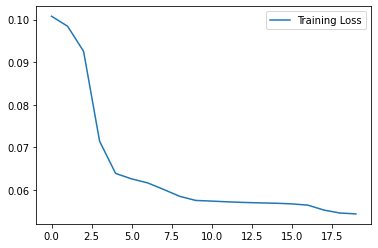

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()